# Programatically understanding dynamic time warping (DTW)

So you just recorded yourself saying a word and try to match it against another instance. The signals look similar, but have varying lengths and different activations for different features. So, how do you decide the similarity. Dynamic time warping (DTW) is probably something which can come to your rescue. Quoting wikipedia:


"In time series analysis, dynamic time warping (DTW) is an algorithm for measuring similarity between two temporal sequences which may vary in time or speed. For instance, similarities in walking patterns could be detected using DTW, even if one person was walking faster than the other, or if there were accelerations and decelerations during the course of an observation."

In this post I will try and put forward a naive implementation of DTW and also explain the different pieces of the problem.

#### Customary imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Creating two signals

In [2]:
x = np.array([1, 1, 2, 3, 2, 0])
y = np.array([0, 1, 1, 2, 3, 2, 1])

#### Plotting the two signals

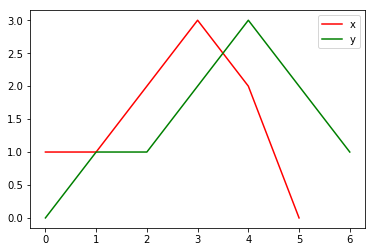

In [3]:
plt.plot(x,'r', label='x')
plt.plot(y, 'g', label='y')
plt.legend();

So, it appears that both the signals show similar behaviour: they both have a peak and around the peak they slop downwards. They vary in their speed and total duration. So, all set for DTW.

#### Aim

Our aim is to find a mapping between all points of x and y. For instance, x(3) may be mapped to y(4) and so on.

#### Making a 2d matrix to compute distances between all pairs of x and y

In this initial step, we will find out the distance between all pair of points in the two signals. Lesser distances implies that these points may be candidates to be matched together.

In [4]:
distances = np.zeros((len(y), len(x)))

In [5]:
distances

array([[ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]])

We will use euclidean distance between the pairs of points.

In [6]:
for i in range(len(y)):
    for j in range(len(x)):
        distances[i,j] = (x[j]-y[i])**2  

In [7]:
distances

array([[ 1.,  1.,  4.,  9.,  4.,  0.],
       [ 0.,  0.,  1.,  4.,  1.,  1.],
       [ 0.,  0.,  1.,  4.,  1.,  1.],
       [ 1.,  1.,  0.,  1.,  0.,  4.],
       [ 4.,  4.,  1.,  0.,  1.,  9.],
       [ 1.,  1.,  0.,  1.,  0.,  4.],
       [ 0.,  0.,  1.,  4.,  1.,  1.]])

#### Visualizing the distance matrix

We will write a small function to visualize the distance matrix we just created.

In [8]:
def distance_cost_plot(distances):
    im = plt.imshow(distances, interpolation='nearest', cmap='Reds') 
    plt.gca().invert_yaxis()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid()
    plt.colorbar();


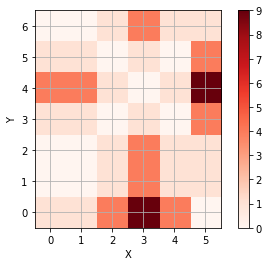

In [9]:
distance_cost_plot(distances)

From the plot above, it seems like the diagonal entries have low distances, which means that the distance between similar index points in x and y is low.

#### Warping path

In order to create a mapping between the two signals, we need to create a path in the above plot. The path should start at (0,0) and want to reach (M,N) where (M, N) are the lengths of the two signals. Our aim is to find the path of minimum distance. To do this, we thus build a matrix similar to the distances matrix. This matrix would contain the minimum distances to reach a specific point when starting from (0,0). We impose some restrictions on the paths which we would explore:
1. The path must start at (0,0) and end at (M,N)
2. We cannot go back in time, so the path only flows forwards, which means that from a point (i, j), we can only right (i+1, j)  or upwards (i, j+1) or diagonal (i+1, j+1).

These restrictions would prevent the combinatorial explosion and convert the problem to a Dynamic Programming problem  which can be solved in O(MN) time.

In [10]:
accumulated_cost = np.zeros((len(y), len(x)))

#### Let us now build up the accumulated cost

* Since we start from (0,0), the accumulated cost at this point is distance(0,0)

In [11]:
accumulated_cost[0,0] = distances[0,0]

Lets see how accumulated cost looks at this point.

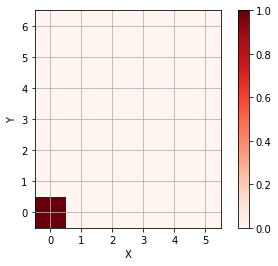

In [12]:
distance_cost_plot(accumulated_cost)

* If we were to move along the first row, i.e. from (0,0) in the right direction only, one step at a time

In [13]:
for i in range(1, len(x)):
    accumulated_cost[0,i] = distances[0,i] + accumulated_cost[0, i-1]    

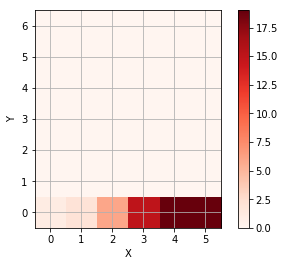

In [14]:
distance_cost_plot(accumulated_cost)

* If we were to move along the first column, i.e. from (0,0) in the upwards direction only, one step at a time

In [15]:
for i in range(1, len(y)):
    accumulated_cost[i,0] = distances[i, 0] + accumulated_cost[i-1, 0]    

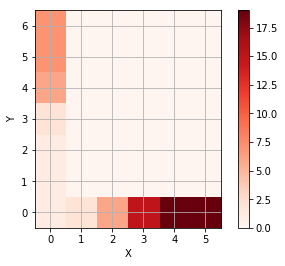

In [16]:
distance_cost_plot(accumulated_cost)

* For all other elements, we have $ \mathrm{Accumulated\ Cost\ (D (i, j)) = \min\{{D(i-1, j-1), D(i-1, j), D(i, j-1)}\} + distance(i, j)}$

In [17]:
for i in range(1, len(y)):
    for j in range(1, len(x)):
        accumulated_cost[i, j] = min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]) + distances[i, j]

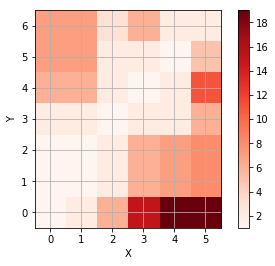

In [18]:
distance_cost_plot(accumulated_cost)

So, now we have obtained the matrix containing cost of all paths starting from (0,0). We now need to find the path minimizing the distance which we do by backtracking.

#### Backtracking and finding the optimal warp path

Backtracking procedure is fairly simple and involves trying to move back from the last point (M, N) and finding which place we would reached there from (by minimizing the cost) and do this in a repetitive fashion.

In [19]:
path = [[len(x)-1, len(y)-1]]
i = len(y)-1
j = len(x)-1
while i>0 and j>0:
    if i==0:
        j = j - 1
    elif j==0:
        i = i - 1
    else:
        if accumulated_cost[i-1, j] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
            i = i - 1
        elif accumulated_cost[i, j-1] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
            j = j-1
        else:
            i = i - 1
            j= j- 1
    path.append([j, i])
path.append([0,0])

In [20]:
path

[[5, 6], [4, 5], [3, 4], [2, 3], [1, 2], [1, 1], [0, 1], [0, 0]]

In [21]:
path_x = [point[0] for point in path]
path_y = [point[1] for point in path]

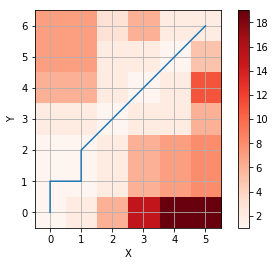

In [22]:
distance_cost_plot(accumulated_cost)
plt.plot(path_x, path_y);

The above plot shows the optimum warping path which minimizes the sum of distance (DTW distance) along the path. Let us wrap up the function by also incorporating the DTW distance between the two signals as well.

In [23]:
def path_cost(x, y, accumulated_cost, distances):
    path = [[len(x)-1, len(y)-1]]
    cost = 0
    i = len(y)-1
    j = len(x)-1
    while i>0 and j>0:
        if i==0:
            j = j - 1
        elif j==0:
            i = i - 1
        else:
            if accumulated_cost[i-1, j] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
                i = i - 1
            elif accumulated_cost[i, j-1] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
                j = j-1
            else:
                i = i - 1
                j= j- 1
        path.append([j, i])
    path.append([0,0])
    for [y, x] in path:
        cost = cost +distances[x, y]
    return path, cost    

In [24]:
path, cost = path_cost(x, y, accumulated_cost, distances)
print (path)
print (cost)

[[5, 6], [4, 5], [3, 4], [2, 3], [1, 2], [1, 1], [0, 1], [0, 0]]
2.0


Let us compare our naive implementation with that of [mlpy](http://mlpy.sourceforge.net/) which also provides a DTW implementation.

In [25]:
import sys
sys.executable
sys.path

['',
 '/home/gilac/anaconda3/lib/python35.zip',
 '/home/gilac/anaconda3/lib/python3.5',
 '/home/gilac/anaconda3/lib/python3.5/plat-linux',
 '/home/gilac/anaconda3/lib/python3.5/lib-dynload',
 '/home/gilac/anaconda3/lib/python3.5/site-packages',
 '/home/gilac/anaconda3/lib/python3.5/site-packages/IPython/extensions',
 '/home/gilac/.ipython']

In [26]:
import mlpy


ImportError: No module named 'mlpy'

In [26]:
dist, cost, path = mlpy.dtw_std(x, y, dist_only=False)

NameError: name 'mlpy' is not defined

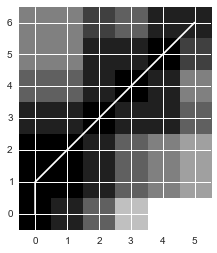

In [27]:
import matplotlib.cm as cm
fig = plt.figure(1)
ax = fig.add_subplot(111)
plot1 = plt.imshow(cost.T, origin='lower', cmap=cm.gray, interpolation='nearest')
plot2 = plt.plot(path[0], path[1], 'w')
xlim = ax.set_xlim((-0.5, cost.shape[0]-0.5))
ylim = ax.set_ylim((-0.5, cost.shape[1]-0.5))

The path looks almost identical to the one we got. The slight difference is due to the fact that the path chosen by our implementation and the one chosen by DTW have the same distance and thus we woulc choose either.

In [28]:
dist

2.0

Not bad! Our implementation gets the same distance between x and y. 

Let us look at another interesting way to visualize the warp. We will place the two signals on the same axis and 

5 0 : 6 1
4 2 : 5 2
3 3 : 4 3
2 2 : 3 2
1 1 : 2 1
1 1 : 1 1
0 1 : 1 1
0 1 : 0 0


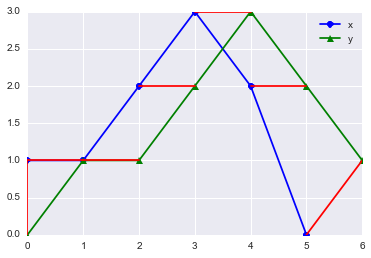

In [29]:
plt.plot(x, 'bo-' ,label='x')
plt.plot(y, 'g^-', label = 'y')
plt.legend();
paths = path_cost(x, y, accumulated_cost, distances)[0]
for [map_x, map_y] in paths:
    print map_x, x[map_x], ":", map_y, y[map_y]
    
    plt.plot([map_x, map_y], [x[map_x], y[map_y]], 'r')

The above plot shows the mapping between the two signal. The red lines connect the matched points which are given by the DTW algorithm Looks neat isn't it? Now, let us try this for some known signal. This example is inspired from the example used in R's dtw implementation. We will see the DTW path between a sine and cosine on the same angles. 

In [30]:
idx = np.linspace(0, 6.28, 100)

In [31]:
x = np.sin(idx)

In [32]:
y = np.cos(idx)

In [33]:
distances = np.zeros((len(y), len(x)))

In [34]:
for i in range(len(y)):
    for j in range(len(x)):
        distances[i,j] = (x[j]-y[i])**2  

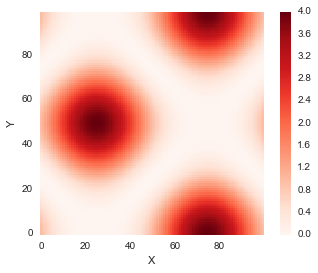

In [35]:
distance_cost_plot(distances)

In [36]:
accumulated_cost = np.zeros((len(y), len(x)))
accumulated_cost[0,0] = distances[0,0]
for i in range(1, len(y)):
    accumulated_cost[i,0] = distances[i, 0] + accumulated_cost[i-1, 0]
for i in range(1, len(x)):
    accumulated_cost[0,i] = distances[0,i] + accumulated_cost[0, i-1] 
for i in range(1, len(y)):
    for j in range(1, len(x)):
        accumulated_cost[i, j] = min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]) + distances[i, j]

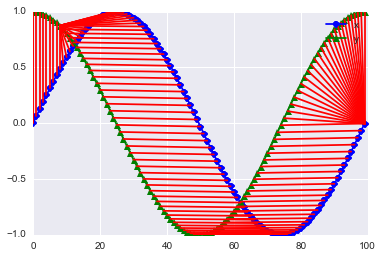

In [37]:
plt.plot(x, 'bo-' ,label='x')
plt.plot(y, 'g^-', label = 'y')
plt.legend();
paths = path_cost(x, y, accumulated_cost, distances)[0]
for [map_x, map_y] in paths:
    #print map_x, x[map_x], ":", map_y, y[map_y]
    
    plt.plot([map_x, map_y], [x[map_x], y[map_y]], 'r')

Ok, this does look nice. I am impressed!

#### Conclusions

We worked out a naive DTW implementation pretty much from scratch. It seems to do reasonably well on artificial data.

#### References

1. [Wikipedia page on dtw](http://en.wikipedia.org/wiki/Dynamic_time_warping)
2. [R's dtw package](http://dtw.r-forge.r-project.org/)
3. [mlpy page on dtw](http://mlpy.sourceforge.net/docs/3.4/dtw.html)
4. [DTW review paper](http://www2.hawaii.edu/~senin/assets/papers/DTW-review2008draft.pdf)

Feel free to comment!